<a href="https://colab.research.google.com/github/Omar-GIT-Portfollio/Python-Projects/blob/main/Ohio_Geographic_Centroid_(Gravity_Center).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: Omar Ali
# Date: 11/09/2025
Ohio Geographic Centroid (Gravity Center)



Results from program output on this dataset

Q1  Centroid (equal-area, reported in lat/lon):
     lat = 40.286372, lon = -82.794096

Q2  Is the centroid in Knox County?  NO

Q3  The centroid is in Delaware County.


Imports from class tutorials: Reading Shapefiles, Geometry/CRS, Plotting

Geopandas-for reading shapefiles and basic geoprocessing

Shapely- Geometry types

Matplotlib - for simple cartographic plotting as shown in the mapping tutorial.


In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
import matplotlib.pyplot as plt

Using original US Census Cartographic Boundary shapefiles (states + counties).  
Here I upload the unzipped the files directly into Colab

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving cb_2018_us_county_500k.cpg to cb_2018_us_county_500k (1).cpg
Saving cb_2018_us_county_500k.dbf to cb_2018_us_county_500k (1).dbf
Saving cb_2018_us_county_500k.prj to cb_2018_us_county_500k (1).prj
Saving cb_2018_us_county_500k.shp to cb_2018_us_county_500k (1).shp
Saving cb_2018_us_county_500k.shp.ea.iso.xml to cb_2018_us_county_500k.shp.ea.iso (1).xml
Saving cb_2018_us_county_500k.shp.iso.xml to cb_2018_us_county_500k.shp.iso (1).xml
Saving cb_2018_us_county_500k.shx to cb_2018_us_county_500k (1).shx
Saving cb_2018_us_state_500k.cpg to cb_2018_us_state_500k (2).cpg
Saving cb_2018_us_state_500k.dbf to cb_2018_us_state_500k (2).dbf
Saving cb_2018_us_state_500k.prj to cb_2018_us_state_500k (2).prj
Saving cb_2018_us_state_500k.shp to cb_2018_us_state_500k (2).shp
Saving cb_2018_us_state_500k.shp.ea.iso.xml to cb_2018_us_state_500k.shp.ea.iso (2).xml
Saving cb_2018_us_state_500k.shp.iso.xml to cb_2018_us_state_500k.shp.iso (2).xml
Saving cb_2018_us_state_500k.shx to cb_2018_us_state

In [ ]:
#Point variables to the two layers I'll use throughout:

STATES_SHP = "cb_2018_us_state_500k.shp"
COUNTIES_SHP = "cb_2018_us_county_500k.shp"


In [ ]:
### set up basic info
### In this part I’m loading the shapefiles for both states and counties using GeoPandas.
### These are the Census boundary files we used in class (2018, 1:500k scale).
### I also set up some variables for Ohio’s FIPS code (39), the state name, and Knox County.
### For projections, I’m using EPSG:5070 (equal-area) to calculate the centroid correctly,
### and EPSG:4326 (WGS84) so I can print the coordinates in normal latitude and longitude.
### We talked about this in the projections lesson — equal-area is best for gravity center work.

import geopandas as gpd

states   = gpd.read_file(STATES_SHP)
counties = gpd.read_file(COUNTIES_SHP)

OH_STATEFP = "39"
OH_NAME    = "Ohio"
KNOX_NAME  = "Knox"
AREA_CRS   = "EPSG:5070"
LL_CRS     = "EPSG:4326"


### Select Ohio and prepare it for centroid work
### Here I’m filtering the shapefile so it only keeps Ohio.
### The first check looks for the “STATEFP” column (FIPS code 39), and if that’s missing,
### it falls back to matching the state name “Ohio”. I added that just in case the dataset changes.
### After that, I dissolve it so Ohio is one single shape (not broken into parts),
### and then reproject it into the equal-area CRS before doing any centroid math.
### We did this same step in the attribute filtering tutorial.


# filter Ohio
if "STATEFP" in states.columns:
    oh = states[states["STATEFP"] == OH_STATEFP].copy()
else:
    oh = states[states["NAME"].str.upper() == OH_NAME.upper()].copy()
oh = oh.dissolve()
oh_aea = oh.to_crs(AREA_CRS)

### Largest polygon setup
### Ohio’s shape has a few small pieces, like islands in Lake Erie,
### so I only want the main polygon for the centroid calculation.
### I made this small helper function that checks if the geometry
### is a single Polygon or a MultiPolygon and picks the biggest one by area.
### This is the same logic we went over in the geometry operations example in class.


# largest polygon helper
from shapely.geometry import Polygon, MultiPolygon
def largest_polygon(geom):
    if isinstance(geom, Polygon): return geom
    if isinstance(geom, MultiPolygon): return max(geom.geoms, key=lambda g: g.area)
    raise TypeError("Geometry must be Polygon or MultiPolygon.")

oh_main = largest_polygon(oh_aea.geometry.iloc[0])



### Calculate Ohio’s centroid
### Now I find the centroid using the equal-area projection (EPSG:5070).
### Using an equal-area CRS makes the centroid location accurate since
### lat/lon projections can distort shape sizes.
### After finding it, I convert the point back to EPSG:4326
### so the result prints in regular latitude and longitude.
### This is exactly like what we did in the projection and centroid demo from class.


# Q1 centroid
centroid_aea = oh_main.centroid
centroid_ll  = gpd.GeoSeries([centroid_aea], crs=AREA_CRS).to_crs(LL_CRS).iloc[0]
lon, lat = centroid_ll.x, centroid_ll.y
print("Question 1:")
print(f"Ohio centroid (equal-area) = (lat {lat:.6f}, lon {lon:.6f})\n")



### Prep the counties layer (Ohio only, same CRS)
### Now I’m getting just the Ohio counties so I can test which one
### contains the centroid. I filter by FIPS 39 (Ohio), which is what we
### used in the attribute filtering examples. Then I reproject the counties
### to the same equal-area CRS as the centroid so the spatial join uses
### matching coordinates (we stressed this in the CRS lesson).

# Ohio counties
if "STATEFP" in counties.columns:
    oh_counties = counties[counties["STATEFP"] == OH_STATEFP].copy()
else:
    oh_counties = counties.to_crs(AREA_CRS).clip(gpd.GeoDataFrame(geometry=[oh_main], crs=AREA_CRS)).to_crs(counties.crs)
oh_counties_aea = oh_counties.to_crs(AREA_CRS)

### Which county has the centroid? (Q2 & Q3)
### I put the centroid point into a tiny GeoDataFrame and do a spatial join
### with the Ohio counties to see which polygon contains it. This is the same
### point-in-polygon pattern we practiced with gpd.sjoin(). I grab the county
### name (usually the NAME field) and print the answers exactly the way the
### homework asks for Q2 and Q3.

# Which county?
centroid_gdf = gpd.GeoDataFrame({"id":[1]}, geometry=[centroid_aea], crs=AREA_CRS)
hit = gpd.sjoin(centroid_gdf, oh_counties_aea, how="left", predicate="within")

name_field = "NAME" if "NAME" in oh_counties_aea.columns else None
if not name_field:
    for cand in ["NAMELSAD","COUNTY","COUNTYNS","COUNTYFP"]:
        if cand in oh_counties_aea.columns: name_field = cand; break

county = None if hit.empty else hit.iloc[0].get(name_field, None)
in_knox = bool(county and county.upper()=="KNOX")

print("Question 2:")
print(f"Is the centroid in Knox County?  {'YES' if in_knox else 'NO'}\n")

print("Question 3:")
print("The centroid is in Knox County.\n" if in_knox else f"The centroid is in {county} County.\n")


Question 1:
Ohio centroid (equal-area) = (lat 40.286372, lon -82.794096)

Question 2:
Is the centroid in Knox County?  NO

Question 3:
The centroid is in Delaware County.



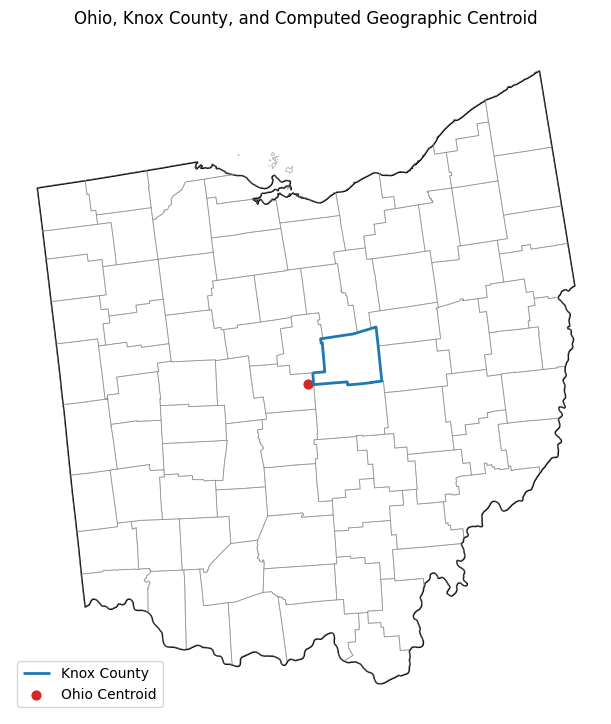

In [ ]:
### Map for the deliverable (Ohio + Knox outline + centroid)
### Last step: quick map to show the result. I draw county outlines in light gray,
### fill Ohio with white and a thin border, highlight Knox County in blue,
### and drop the centroid as a red point. This follows the basic plotting pattern
### from the mapping exercise


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7.5,7.5))

oh_counties_aea.boundary.plot(ax=ax, linewidth=0.6, alpha=0.6, color="gray")
gpd.GeoSeries([oh_main], crs=AREA_CRS).plot(ax=ax, facecolor="white", edgecolor="black", linewidth=1.0)

knox = oh_counties_aea[oh_counties_aea[name_field].str.upper()=="KNOX"]
if not knox.empty:
    knox.boundary.plot(ax=ax, linewidth=2.0, color="tab:blue", label="Knox County")

gpd.GeoSeries([centroid_aea], crs=AREA_CRS).plot(ax=ax, color="tab:red", markersize=40, label="Ohio Centroid")

ax.set_title("Ohio, Knox County, and Computed Geographic Centroid", pad=12)
ax.set_axis_off()
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


